# Test de la simulation
> Conditionnement de la représentation par équipe 

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import csv
import seaborn as sns
import corner
from pathlib import Path

In [19]:
def cumul_avg(tab):
    """Given a list of computable values (int/float)
    computes the corresponding list of moving average
    (cumulative average)

    Arguments:
        tab {List[int]} -- List of observed values

    Returns:
        {List[int]} -- Corresponding list of moving average
    """

    res = list()
    res = np.cumsum(tab) / np.arange(1, len(tab) + 1)
    return res


def cdf(data):
    """ CDF : Cumulative Distribution function
    Returns the Cumulative Distribution of the dataset (data)

    Arguments:
        data {List[float]} -- dataset

    Returns:
        {List[foat], List[float]} -- absciss, ordinate
    """

    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y


def display(dataset,  prefix="", obs=None):
    """Creates a fil displaying a summary of the model

    Arguments:
        results {List[GraphWrapper)] -- instance of the graph
                                        for each iteration
        summary_fct {fonction} -- function returning a summary dict
        title {str} -- Figure's title

    Keyword Arguments:
        prefix {str} -- filen (default: {""})
    """
    """
    Displays five different charts

    Arguments:
        results {[type]} - - [description]

    Keyword Arguments:
        prefix {str} - - [description](default: {""})
    """

    fig = plt.figure(figsize=(10, 10))

    for idx, label in enumerate(dataset):
        ax = plt.subplot(len(dataset), 1, idx + 1)
        ax.plot(dataset[label], label='Sample value')
        ax.plot(cumul_avg(dataset[label]), label='Cumulative average')
        if obs is not None:
            ax.axhline(y=obs[idx], color='r')
        ax.set_ylabel(label)

    plt.legend()
    plt.xlabel("Iterations")

    plt.subplots_adjust(hspace=0.4)
    plt.suptitle('Metropolis hasting algorithm : Markov model')

    fig.savefig(prefix + "chain.pdf")


def dist_display(dataset, prefix=""):
    """Displays the samples’ distribution.

    Arguments:
        results {List[GraphWrapper]} -- List of resulting graph
                                        for each iteration

        summary_fct {fonction} -- function returning a summary dict

    Keyword Arguments:
        prefix {str} -- filename prefix (default: {""})
    """

    fig = plt.figure(figsize=(20, 20))
    fig.suptitle('Distribution Summary', fontsize=30)
    # Creates a grid with as many rows as entries in dataset and 2 columns
    # The first column is dedicated to the histogramme
    # The second one is dedicated to the CDF
    grid = plt.GridSpec(len(dataset), 3, hspace=0.6)

    for idx, label in enumerate(dataset):
        # Iterates over each grid's line
        hist_area = fig.add_subplot(grid[idx, 0])
        cdf_area = fig.add_subplot(grid[idx, 1])
        qq_plot_area = fig.add_subplot(grid[idx, 2])

        hist_area.set_title('{} Distribution'.format(label))
        hist_area.set_xlabel('Observed value')
        hist_area.set_ylabel('Distribution density')
        hist_area.hist(dataset[label], bins=50)

        cdf_area.set_title('{}\' CDF'.format(label))
        cdf_area.set_xlabel('Observed value')
        cdf_area.set_ylabel('Density')
        cdf_x, cdf_y = cdf(dataset[label])
        cdf_area.plot(cdf_x, cdf_y)

        stats.probplot(dataset[label], dist="norm", plot=qq_plot_area)
        qq_plot_area.set_title("Potts Q-Q plot for {}".format(label))
        qq_plot_area.get_lines()[0].set_markerfacecolor('C0')
        qq_plot_area.get_lines()[1].set_color('C2')

    fig.savefig(prefix + "dist.pdf")

def read_raw_traces(path):
    with open(path, 'r') as file:
        reader = csv.reader(file)
        raw_data = list()
        try:
            for row in reader:
                raw_data.append([float(r) for r in row])
        except ValueError:
            print("error", row)
    data_trans = np.array(raw_data).transpose()
    return data_trans

def extract_posterior_dist(path, burn_in=0, by=1):
    data_trans = read_raw_traces(path)
    data_frame = pd.DataFrame({r'$\theta_{11}$': [b for b in data_trans[0][burn_in::by]],
                               r'$\theta_{12}$': [b for b in data_trans[1][burn_in::by]],
                               r'$\theta_{22}$': [b for b in data_trans[2][burn_in::by]]})
    return data_frame

def extract_sim_traces(path):
    data_trans = read_raw_traces(path)
    data = dict()
    data[r"$t_{01}(y)$"] = data_trans[0][1:]
    data[r"$t_{02}(y)$"] = data_trans[1][1:]
    data[r"$t_{12}(y)$"] = data_trans[2][1:]
    return data

def plot_marginals(data_abc, perfect_vals, burn_in=0, by=1):
    
    col_names = data_abc.columns.values
    
    fig, axs = plt.subplots(len(col_names), 2, figsize=(14,25))
    
    for idx, param_name in np.ndenumerate(col_names):
        i = idx[0]
        # Sample parameter
        params = data_abc[param_name].tolist()[burn_in::by]

        # Distribution
        sns.distplot(params, axlabel="{} distribution ABC".format(param_name), ax=axs[i, 0])
        axs[i, 0].axvline(perfect_vals[i], color='r', linestyle='--', label='expected value')

        # Path
        axs[i, 1].plot(range(len(params)), params)
        axs[i, 1].axhline(perfect_vals[i], color='r', linestyle='--', label='expected value')
        axs[i, 1].set(xlabel='iterations', ylabel='{} parameter ABC'.format(param_name))

def print_config(path) :
    with open(path) as f:
        lines = f.readlines()
    for l in lines:
        if not l.startswith("#") and len(l):
            print(l.rstrip())

def MAP_computation(data_abc, burn_in=0, by=1):
    col_names = data_abc.columns.values
    map_vec = list()
    for idx, col_name in np.ndenumerate(col_names):
        i = idx[0]
        p=sns.kdeplot(data_abc[col_name][burn_in::by], shade=True)
        x = p.lines[i].get_xdata()
        y = p.lines[i].get_ydata()
        max_theta = np.around(x[np.argmax(y)], decimals=4)
        map_vec.append(max_theta)
    return map_vec

def corner_plot(data_post, map_theta, truths, output_path, print_truths=True, burn_in=0, by=1):
    data = data_post[burn_in::by]
    fig = corner.corner(data.values, quantiles=(0.25, 0.50, 0.75), bins=30, labels=[r"$\theta_{11}$", r"$\theta_{12}$", r"$\theta_{22}$"], truths=map_theta, show_titles=True, title_kwargs={"fontsize": 12})
    axes = np.array(fig.axes).reshape((3, 3))
    if print_truths:
        for i in range(3):
            ax = axes[i, i]
            ax.axvline(truths[i], color="g")

        for yi in range(3):
            for xi in range(yi):
                ax = axes[yi, xi]
                ax.axvline(truths[xi], color="g")
                ax.axhline(truths[yi], color="g")
                ax.plot(truths[xi], truths[yi], "sg")
    plt.savefig(output_path)
    
def summary(data, burnin=0, by=1):
    col_names = data.columns.values
    for i in [10,25,50,75,95]:
        print("========== Q{} ==========".format(i))
        for _, param_name in np.ndenumerate(col_names):
            q = np.around(np.percentile(data[param_name][burnin::by], i), decimals=3)
            print("Q{} for {} parameter {}".format(i, param_name, q))
    print("========== mean ==========")
    for _, param_name in np.ndenumerate(col_names):
        mean = np.around(np.mean(data[param_name]), decimals=3)
        print("mean for {} parameter {}".format(param_name, mean))


In [15]:
OUTPUT_DIR = "./outputs/figures/test_sim"
output_path = Path(OUTPUT_DIR)
BY = 100
BURNIN = 2000

## Example $2 \leftrightarrow 2$
> $\theta = [-0.1,-0.1,0.8]$, `GraphWrapper(10,10,10)`

In [16]:
sim_traces = extract_sim_traces("./assets/test_sim/sim_traces_INTER.csv")

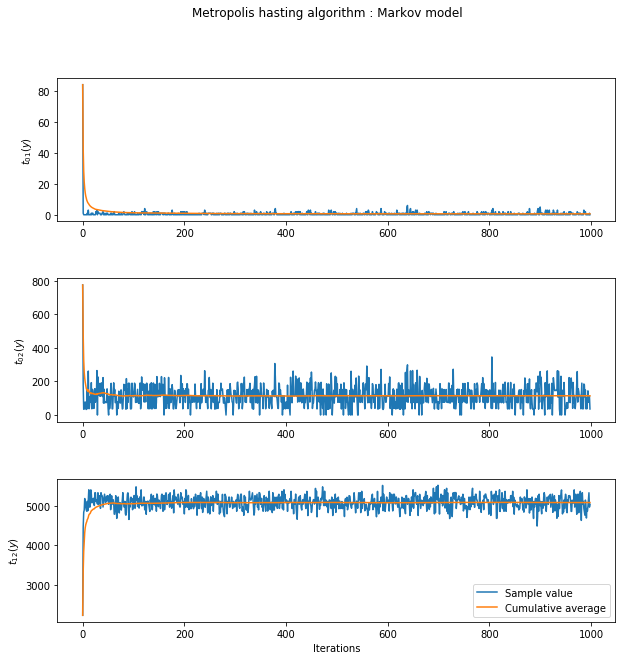

In [17]:
display(sim_traces)

## MAP computed with geometric configuration

In [21]:
sim_traces_geo = extract_sim_traces("./assets/test_sim/test_traces_MAP_GEO2.csv")

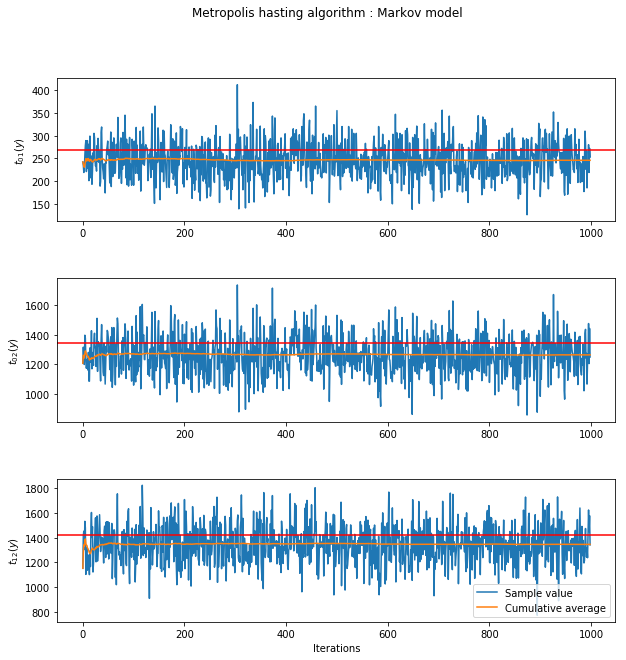

In [22]:
display(sim_traces_geo, obs=[268.415,1343.96,1418.85])